# ***Pavement Layered Elastic Analysis*** 
3D layered elastic analysis for calculating stresses and starains in flexible pavements. Currently only works for fully bonded layers. This program is for instructional purposes only and may contain errors. For source code, visit [github/egemenokte](https://github.com/egemenokte/3DLayeredElastic).

This program is built on top of PyMastic [github/Mostafa-Nakhaei](https://github.com/Mostafa-Nakhaei/PyMastic). It is parallelized to make operations faster. Please note that responses near the surface are not reliable.


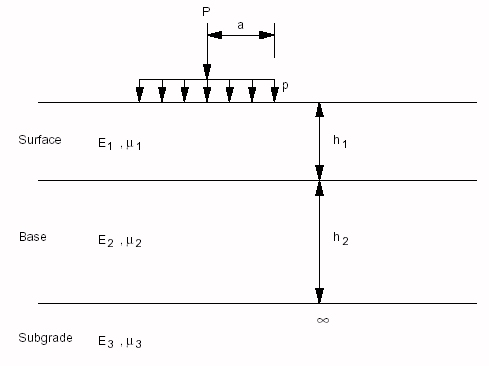

Side note, for quasi-static analysis, if you have your modulus data, you can use 

freq(Hz)=0.2167\*V\*exp(-0.6398\*ln(a)-0.3112\*ln(z)+2.6780). 

V=vehicle speed (kmh), a=contact radius (cm), z=depth (cm). Adapted from [Ghanizadeh et-al]( https://www.sciencedirect.com/science/article/pii/S1996681416301468)

# Step 0) First Things First! Mount your Colab to GitHUB

*   You are given a GitHub repository (you can download and run yourself if you want)
*   Please follow the instructions provided in this document to execute and analyze data
*   Work your way sequentially, following the instructions above each cell.
*   If you run into errors, restart runtime from the Runtime tab.










In [1]:
!git clone https://github.com/egemenokte/3DLayeredElastic.git
%cd 3DLayeredElastic/Run

#Import packages necessary for analysis
import sys
import os
sys.path.append('..')
from Main.MDA_Huang import Layer3D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import ipywidgets as widgets
from IPython.display import display
from google.colab import files
from ipywidgets import interact, interactive, fixed, interact_manual

#Function for converting everything to a dataset
def fewpoints(x,y,z,RSO,download):

  columns=['x','y','z']+list(RSO.keys())
  length=np.size(RSO[list(RSO.keys())[0]])
  DF=pd.DataFrame(data=np.zeros([length,len(columns)]),columns=columns)
  counter=0
  for xx in range(len(x)):
    for yy in range(len(y)):
      for zz in range(len(z)):
        DF.loc[counter,'x']=x[xx]
        DF.loc[counter,'y']=y[yy]
        DF.loc[counter,'z']=z[zz]
        for col in columns[3:]:
          mult=1
          if col[:3]=='eps':
            mult=10**6
          DF.loc[counter,col]=RSO[col][yy,xx,zz]*mult
        counter=counter+1
  if download:
    DF.to_excel("PLEA.xlsx") 
    files.download('PLEA.xlsx')
  return DF

for i in range(10):
    clear_output(wait=True)
    print("All good, move to the next step")

All good, move to the next step


# Step 1) Run Layered Elastic Analysis for a few points
You are given a structure with specific properties. You can change the modulus/thickness of different layers to see its impact on the design. Units have to be consistent, same with WinJulea. In this module only, strains are reported in microstrains

In [2]:
## INPUTS, PLEASE USE CONSISTENT UNITS, SAME AS WIINJULEA
## YOU CAN CHANGE THESE PARAMETERS IF NECESSARY, ################################
E = np.array([500, 50, 10])*1000   # Layer Modulus (psi), [Top Layer, Second to top layer,...,Subgrade]
H = [6, 18]                        # Layer Thicknesses (inch), [Top Layer, Second to top layer,...,nth layer]. Subgrade is not required and assumed semi-infinite
nu = [0.35, 0.4, 0.45]             # Poissons ratio, [Top Layer, Second to top layer,...,Subgrade]
L=[9000,9000]                      # Load Magnitudes (lbs)
LPos=[(10,0),(20,0)]               # Load positions as (x,y) (inch)
a = 4                              # Contact radius (inch)
x = [10,15,20]                     # x query points for (inch) 
y=[0]                              # y query points (inch) 
z =[5.99]                          # z (depth) query points (inch)
download=False                     #download results as an excel file? [True or False]

'''Function Layer3D returns RS dictionary with keys

'deflection_z', 'sigma_x', 'sigma_y', 'sigma_z', 
'sigma_xy', 'sigma_yz', 'sigma_xz', 'eps_x', 
'eps_y', 'eps_z', 'eps_xy','eps_yz', 'eps_xz'

each contains the response (key) 
at coordinates (y,x,z) --> RS[key][y,x,z]

'''
###############################################################################

##### Layered elastic analysis settings. Do not change unless slow or unstable
ZRO=7*1e-20                 # definition of zero to avoid division by zero
isBD=np.ones(len(E))        # assumes fully bonded
it = 1600                   # maximum number of iterations
tolerance=0.01             # average percent error of query points
every=10                    # check for convergence every x steps
#######
print('Running Elastic Analysis...')
RSO=Layer3D(L,LPos,a,x,y,z,H,E,nu,it,ZRO,isBD,tolerance,verbose=True,every=every)
print('Done')

## Save to a pandas dataset to display
for i in range(10):
    clear_output(wait=True)

DF=fewpoints(x,y,z,RSO,download) #Save as a dataframe and then display
DF

,x,y,z,deflection_z,sigma_x,sigma_y,sigma_z,sigma_xy,sigma_yz,sigma_xz,eps_x,eps_y,eps_z,eps_xy,eps_yz,eps_xz
0,10.0,0.0,5.99,0.026031,-145.258597,-185.898003,37.170729,-4.976892e-15,7.162173e-16,-5.848358,-186.408101,-296.134499,306.151077,-2.687522e-14,3.867574e-15,-31.581136
1,15.0,0.0,5.99,0.026725,-113.304041,-183.441599,36.672261,-4.294687e-15,1.019314e-15,0.000000,-123.869545,-313.240953,281.066471,-2.319131e-14,5.504295e-15,0.000000
2,20.0,0.0,5.99,0.026031,-145.258597,-185.898003,37.170729,0.000000e+00,0.000000e+00,5.848358,-186.408101,-296.134499,306.151077,0.000000e+00,0.000000e+00,31.581136


# Step 2) Run Layered Elastic Analysis for Visualization
We can also run this analysis on a grid to visualize outputs bette by changing the z and x values to an array

In [3]:
## YOU CAN CHANGE THESE PARAMETERS IF NECESSARY################################
E = np.array([500, 50, 10])*1000   # Layer Modulus (psi), [Top Layer, Second to top layer,...,Subgrade]
H = [6, 18]                        # Layer Thicknesses (inch), [Top Layer, Second to top layer,...,nth layer]. Subgrade is not required and assumed semi-infinite
nu = [0.35, 0.4, 0.45]             # Poissons ratio, [Top Layer, Second to top layer,...,Subgrade]
L=[9000,9000]                      # Load Magnitudes (lbs)
LPos=[(10,0),(20,0)]               # Load positions as (x,y) (inch)
a = 4                              # Contact radius (inch)
x = np.arange(0,30,1)              # x query points for (inch) 
y=[0]                              # y query points (inch) 
z =np.arange(0,30,1)               # z (depth) query points (inch)
###############################################################################

############################ DO NOT CHANGE BELOW THIS LINE#####################
## Layered elastic analysis settings. Do not change unless slow or unstable
ZRO=7*1e-20
isBD=np.ones(len(E))
it = 1600            # number of maximum iterations
tolerance=0.01       # average percent error of query points
every=100            # check for convergence every x steps
print('Running Elastic Analysis...')
RS=Layer3D(L,LPos,a,x,y,z,H,E,nu,it,ZRO,isBD,tolerance,verbose=True,every=every)
print('Done')
sns.set(rc={'figure.figsize':(20,10)},font_scale=1.15)

Running Elastic Analysis...
Load  1 / 2
iteration 200  error: 0.3045 %
iteration 300  error: 0.0126 %
iteration 400  error: 0.0151 %
iteration 500  error: 0.0026 %
Load  2 / 2
iteration 200  error: 0.4217 %
iteration 300  error: 0.0214 %
iteration 400  error: 0.0159 %
iteration 500  error: 0.006 %
Done


# Step 3) Heatmaps
Let's see the results by plotting them as a heatmap at first y index. You can manually change the response to change which response to plot. Please use keys or column names as reference


Text(0.5, 1.0, 'sigma_z')

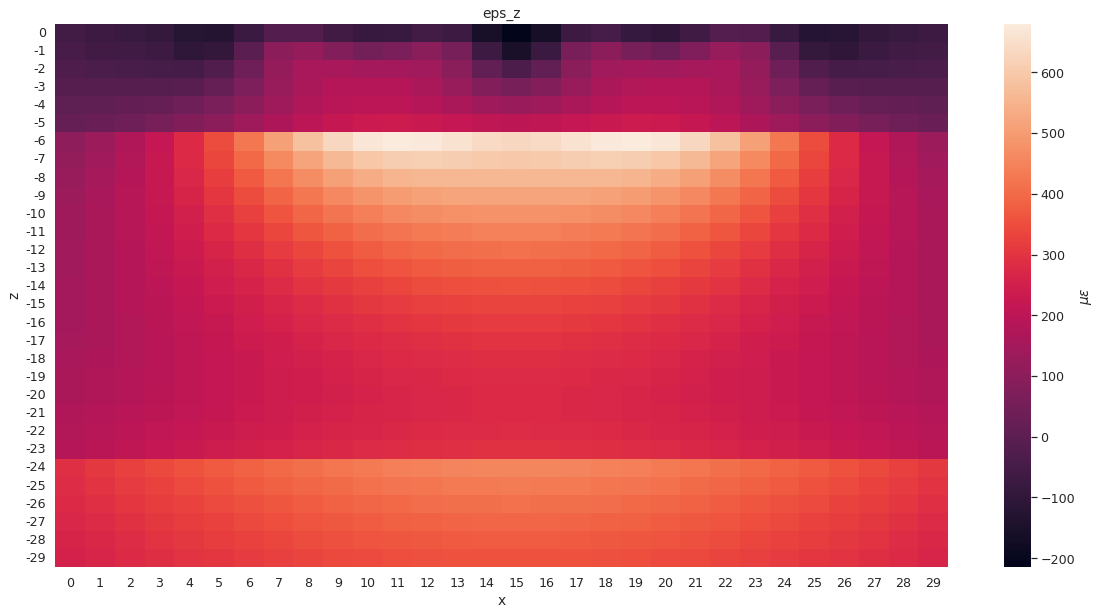

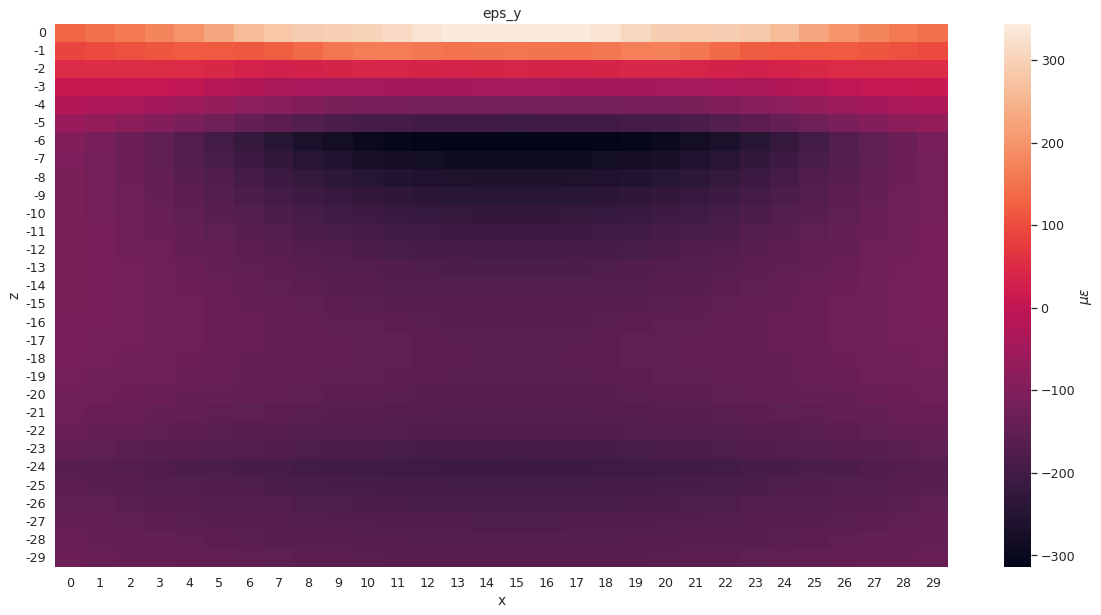

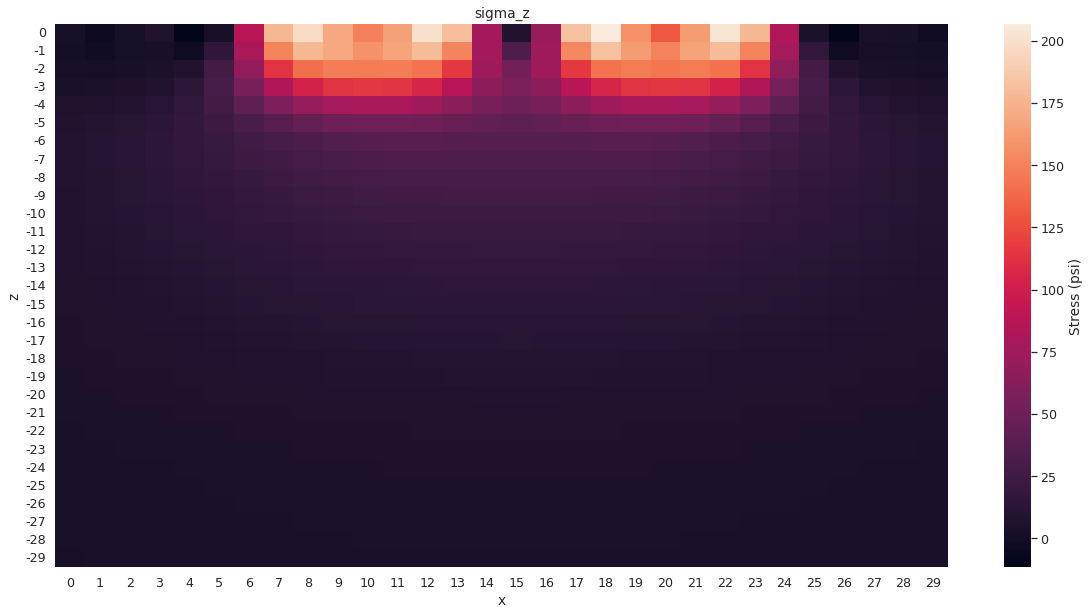

In [5]:
sns.set(rc={'figure.figsize':(20,10)},font_scale=1.15)
z=np.array(z)
plt.close('all')

plt.figure()
response='eps_z' 
A=np.transpose(RS[response][0,:,:])*10**6
sns.heatmap(A,xticklabels=x,yticklabels=-z,cbar_kws={'label': '$\mu\epsilon$'}) #positive is compression
plt.xlabel('x')
plt.ylabel('z')
plt.title(response)

plt.figure()
response='eps_y' 
A=np.transpose(RS[response][0,:,:])*10**6
sns.heatmap(A,xticklabels=x,yticklabels=-z,cbar_kws={'label': '$\mu\epsilon$'})
plt.xlabel('x')
plt.ylabel('z')
plt.title(response)

plt.figure()
response='sigma_z' 
A=np.transpose(RS[response][0,:,:])
sns.heatmap(A,xticklabels=x,yticklabels=-z,cbar_kws={'label': 'Stress (psi)'})
plt.xlabel('x')
plt.ylabel('z')
plt.title(response)

#To plot deflections. 

#fig, ax = plt.subplots(figsize=(10, 8))
#response='deflection_z' 
#mag=50
#X,Z=np.meshgrid(x,z)
#A=np.transpose(RS[response][0,:,:])*mag
# A=RS['sigma_z'][0,:,:]
#ax.scatter(X.flatten(),-Z.flatten(),s=0.5)
#ax.scatter(X.flatten(),-Z.flatten()-A.flatten())
#ax.set_xticks(x)
#ax.set_yticks(-z)
#plt.title('Deformation field magnified '+str(mag)+' times')
#plt.xlabel('x')
#plt.ylabel('z')
# plt.grid()

#ax.quiver(X,-Z,-A*0,-A,-A, scale_units='xy', scale=1.)

# Step 4) Plotting with respect to depth at a given x 
Plotting with respect to depth for a given x. You can change the interactive dialogs to plot different responses. Please use keys or column names for reference. For instance, use 'eps_z' for compressive vertical strain

In [4]:
idx=(np.abs(np.array(x) - LPos[0][0])).argmin() #index under the load by default
response='sigma_z' #default
@interact(xx=widgets.IntSlider(min=0, max=len(x)-1, step=1, value=idx), response='sigma_z')
def plotx(response=response,xx=0):
  response=response
  A=np.transpose(RS[response][0,:,:])
  idx=xx
  sns.scatterplot(x=A[:,idx],y=-z,s=70) #plot the idx x element from left
  plt.xlabel('response (response units)')
  plt.ylabel('z')
  plt.title(response+' ind='+str(idx)+', x='+str(x[idx]))

interactive(children=(Text(value='sigma_z', description='response'), IntSlider(value=10, description='xx', max…

# Step 5) Plotting with respect to x at a given depth
Plotting with respect to x for a given depth. You can change the interactive dialogs to plot different responses. Please use keys or column names for reference. For instance, use 'eps_z' for compressive vertical strain

In [6]:
response='sigma_z' #default
@interact(depth=widgets.IntSlider(min=0, max=len(z)-1, step=1, value=3), response='sigma_z')
def plotz(response=response,depth=0):
  response=response
  depthindex = depth 
  #depthindex=6 #how deep do we want to go?
  A=np.transpose(RS[response][0,:,:])

  sns.scatterplot(y=A[depthindex,:],x=x,s=70) #plot the idx x element from left
  plt.xlabel('x')
  plt.ylabel('response (response units)')
  plt.title(response+' at z ='+str(z[depth]))


interactive(children=(Text(value='sigma_z', description='response'), IntSlider(value=3, description='depth', m…

# Step 6) Comparing Different Structures
We can compare different structures by running additional analysis and keeping the previous one as baseline

In [7]:
## YOU CAN CHANGE THESE PARAMETERS IF NECESSARY################################
E = np.array([500, 50, 10])*1000   # Layer Modulus (psi), [Top Layer, Second to top layer,...,Subgrade]
H = [2, 18]                         # Layer Thicknesses (inch), [Top Layer, Second to top layer,...,nth layer]. Subgrade is not required and assumed semi-infinite
nu = [0.35, 0.4, 0.45]             # Poissons ratio, [Top Layer, Second to top layer,...,Subgrade]
L=[9000,9000]                      # Load Magnitudes (lbs)
LPos=[(10,0),(20,0)]               # Load positions as (x,y) (inch)
a = 4                              # Contact radius (inch)
x = x                              # keep the same with the previous structrue! x query points for (inch) 
y = y                              # keep the same with the previous structrue! y query points (inch) 
z = z                              # keep the same with the previous structrue! z (depth) query points (inch)
###############################################################################
print('Running Elastic Analysis...')
RS2=Layer3D(L,LPos,a,x,y,z,H,E,nu,it,ZRO,np.ones(len(E)),tolerance,verbose=True)
print('Done')

Running Elastic Analysis...
Load  1 / 2
iteration 200  error: 0.7867 %
iteration 300  error: 0.0213 %
iteration 400  error: 0.0151 %
iteration 500  error: 0.0022 %
Load  2 / 2
iteration 200  error: 1.1313 %
iteration 300  error: 0.0396 %
iteration 400  error: 0.0169 %
iteration 500  error: 0.0056 %
Done


Plotting with respect to depth for a given x. You can change the response to plot different responses. Please use keys or column names for reference. For instance, use 'eps_z' for compressive vertical strain

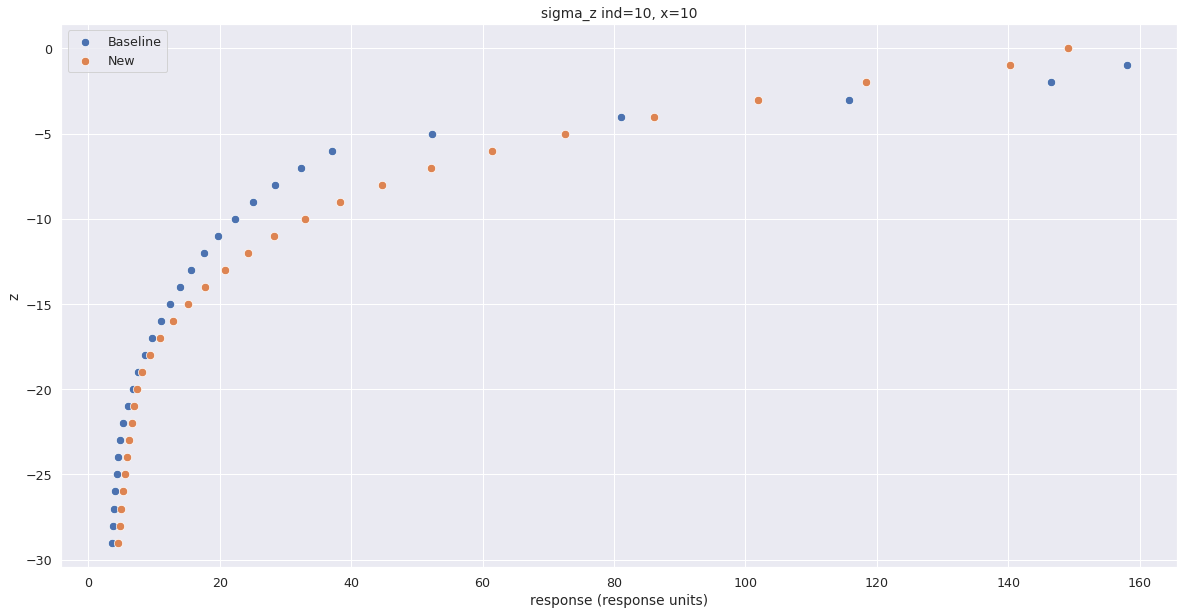

In [8]:
response='sigma_z' 
A=np.transpose(RS[response][0,:,:])
B=np.transpose(RS2[response][0,:,:])
# A=RS['sigma_z'][0,:,:]
idx = (np.abs(np.array(x) - LPos[0][0])).argmin() #index under the load
sns.scatterplot(x=A[:,idx],y=-z,s=70,label='Baseline') #plot the idx x element from left
sns.scatterplot(x=B[:,idx],y=-z,s=70,label='New') #plot the idx x element from left
plt.xlabel('response (response units)')
plt.ylabel('z')
plt.title(response+' ind='+str(idx)+', x='+str(x[idx]))
plt.legend()